In [14]:
import sys
print(sys.executable)

/usr/bin/python3


### Import des bibliothèques

In [15]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Initialiser Spark avec le connecteur Cassandra
spark = SparkSession.builder \
    .appName("Clustering with PySpark") \
    .config("spark.cassandra.connection.host", "172.18.0.2") \
    .config("spark.cassandra.connection.port", "9042") \
    .config("spark.cassandra.auth.username", "cassandra") \
    .config("spark.cassandra.auth.password", "cassandra") \
    .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.12:3.2.0") \
    .getOrCreate()

### Chargement des données 

In [17]:
# Charger les données depuis Cassandra
catalogue = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="catalogue", keyspace="concessionnaire") \
    .load()

immatriculations = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="immatriculation", keyspace="concessionnaire") \
    .load()

### Prétraitement des données

In [18]:
# Afficher les premières lignes
print("Aperçu des données du catalogue :")
catalogue.show(5)

Aperçu des données du catalogue :


25/01/19 00:15:22 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


+--------+---------+-------+--------+--------+--------+--------+--------------------+---------+
|  marque|      nom|couleur|longueur|nbplaces|nbportes|occasion|                prix|puissance|
+--------+---------+-------+--------+--------+--------+--------+--------------------+---------+
|Daihatsu|Cuore 1.0|  blanc|  courte|       5|       3|   false|8850.000000000000...|       58|
|Daihatsu|Cuore 1.0|   bleu|  courte|       5|       3|   false|8850.000000000000...|       58|
|Daihatsu|Cuore 1.0|   gris|  courte|       5|       3|   false|8850.000000000000...|       58|
|Daihatsu|Cuore 1.0|   noir|  courte|       5|       3|   false|8850.000000000000...|       58|
|Daihatsu|Cuore 1.0|  rouge|  courte|       5|       3|   false|8850.000000000000...|       58|
+--------+---------+-------+--------+--------+--------+--------+--------------------+---------+
only showing top 5 rows



In [19]:
# Séparer les voitures neuves et d'occasion
catalogue_new = catalogue.filter(col("occasion") == False)

In [20]:
# Supprimer les doublons des voitures neuves en fonction du nom
catalogue_new = catalogue_new.dropDuplicates(["nom"])

In [21]:
# Encodage ordinal de la colonne 'longueur'
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="longueur", outputCol="longueur_index", stringOrderType="alphabetAsc")
catalogue_new = indexer.fit(catalogue_new).transform(catalogue_new)

25/01/19 00:15:23 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


In [22]:
# Sélectionner uniquement les colonnes numériques
numeric_cols = ["puissance", "longueur_index", "nbplaces", "nbportes", "prix"]
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
catalogue_new = assembler.transform(catalogue_new)

In [23]:
# Normalisation des données
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(catalogue_new)
catalogue_new = scaler_model.transform(catalogue_new)

25/01/19 00:15:23 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


In [24]:
catalogue_new.show(3)

25/01/19 00:15:24 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


+--------+-----------+-------+--------+--------+--------+--------+--------------------+---------+--------------+--------------------+--------------------+
|  marque|        nom|couleur|longueur|nbplaces|nbportes|occasion|                prix|puissance|longueur_index|            features|     scaled_features|
+--------+-----------+-------+--------+--------+--------+--------+--------------------+---------+--------------+--------------------+--------------------+
|  Nissan| Almera 1.8|  blanc| moyenne|       5|       5|   false|16450.00000000000...|      115|           2.0|[115.0,2.0,5.0,5....|[-0.2916059217599...|
|Daihatsu|  Cuore 1.0|  blanc|  courte|       5|       3|   false|8850.000000000000...|       58|           0.0|[58.0,0.0,5.0,3.0...|[-1.3997084244475...|
| Renault|Espace 2.0T|   bleu|  longue|       7|       5|   false|30350.00000000000...|      165|           1.0|[165.0,1.0,7.0,5....|[0.68041381743977...|
+--------+-----------+-------+--------+--------+--------+--------+----

### Clustering

In [25]:
# Clustering avec KMeans
kmeans = KMeans(featuresCol="scaled_features", k=4, seed=123)
model = kmeans.fit(catalogue_new)
catalogue_new = model.transform(catalogue_new)

25/01/19 00:15:25 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance
25/01/19 00:15:25 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance
25/01/19 00:15:26 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance
25/01/19 00:15:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/19 00:15:28 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


In [26]:
# Afficher les clusters
print("Résultats du clustering :")
catalogue_new.select("marque", "nom", "puissance", "prix", "prediction").show()

Résultats du clustering :


25/01/19 00:15:29 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


+----------+----------------+---------+--------------------+----------+
|    marque|             nom|puissance|                prix|prediction|
+----------+----------------+---------+--------------------+----------+
|    Nissan|      Almera 1.8|      115|16450.00000000000...|         2|
|  Daihatsu|       Cuore 1.0|       58|8850.000000000000...|         1|
|   Renault|     Espace 2.0T|      165|30350.00000000000...|         3|
|     Honda|        FR-V 1.7|      125|19550.00000000000...|         3|
|Volkswagen|    Golf 2.0 FSI|      150|22900.00000000000...|         2|
|   Renault|     Laguna 2.0T|      170|27300.00000000000...|         2|
|     Dacia|   Logan 1.6 MPI|       90|7500.000000000000...|         2|
|   Hyundaï|      Matrix 1.6|      103|15960.00000000000...|         3|
|    Nissan|   Maxima 3.0 V6|      200|30000.00000000000...|         0|
|   Renault|  Megane 2.0 16V|      135|22350.00000000000...|         2|
|Volkswagen|  New Beatle 1.8|      110|26630.00000000000...|    

25/01/19 00:15:30 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


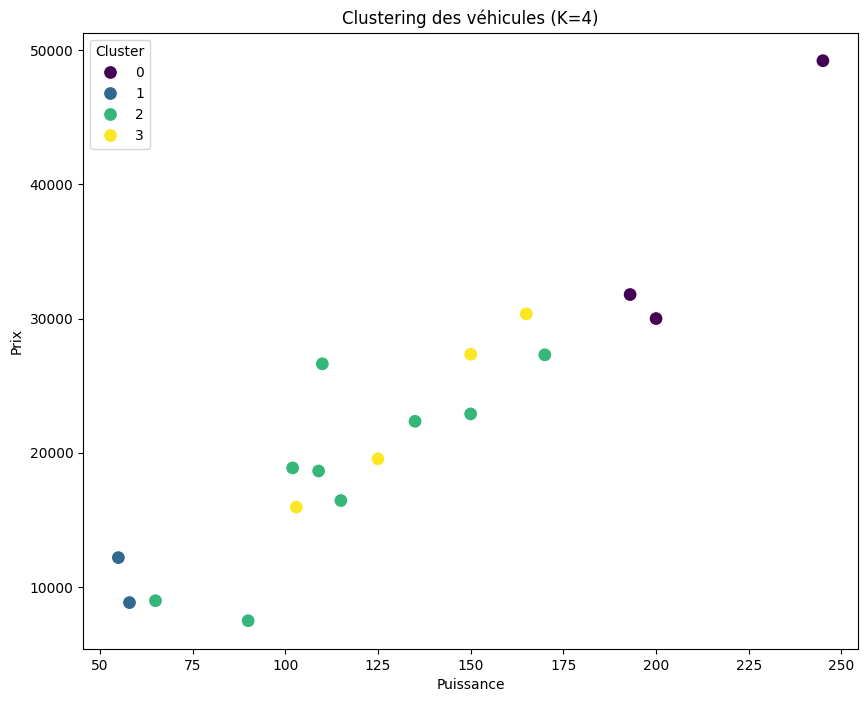

In [27]:
# Visualisation des clusters (nécessite la conversion en Pandas)
catalogue_new_pd = catalogue_new.select("puissance", "prix", "prediction").toPandas()

plt.figure(figsize=(10, 8))
sns.scatterplot(x="puissance", y="prix", hue="prediction", data=catalogue_new_pd, palette="viridis", s=100)
plt.title("Clustering des véhicules (K=4)")
plt.xlabel("Puissance")
plt.ylabel("Prix")
plt.legend(title="Cluster")
plt.show()

In [36]:
# Sélectionner uniquement les colonnes nécessaires pour la sauvegarde
columns_to_save = ["marque", "nom", "couleur", "puissance", "longueur", "nbplaces", "nbportes", "prix", "prediction"]
catalogue_new_selected = catalogue_new.select(columns_to_save)

# Sauvegarder les données avec les clusters
catalogue_new_selected.write.csv("data/clustered/catalogue_clusters.csv", header=True, mode="overwrite")

25/01/19 00:23:25 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


In [33]:
# CREATE TABLE concessionnaire.catalogue_clusters (
#     marque text,
#     nom text,
#     couleur text,
#     puissance int,
#     longueur text,
#     nbplaces int,
#     nbportes int,
#     prix decimal,
#     prediction int,
#     PRIMARY KEY (marque, nom, couleur)
# );

In [37]:
# Sauvegarder les données avec les clusters dans Cassandra 
catalogue_new_selected.write \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="catalogue_clusters", keyspace="concessionnaire") \
    .mode("append") \
    .save()
print("Données sauvegardées avec succès dans Cassandra.")

25/01/19 00:23:29 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


Données sauvegardées avec succès dans Cassandra.


#### Ajouter les clusters à immatriculations

In [42]:
# Fusionner les clusters du catalogue avec les immatriculations
catalogue_clusters = catalogue_new.select("marque", "nom", "prediction")
immatriculations_with_clusters = immatriculations.join(catalogue_clusters, on=["marque", "nom"], how="left")

In [43]:
# Filtrer les immatriculations pour ne garder que les voitures neuves
immatriculations_with_clusters = immatriculations_with_clusters.filter(col("occasion") == False)

In [44]:
# Sauvegarder les immatriculations avec les clusters
immatriculations_with_clusters.write.csv("data/clustered/immatriculations_clusters.csv", header=True, mode="overwrite")

25/01/19 00:27:10 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance
25/01/19 00:27:10 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


In [45]:

# CREATE TABLE concessionnaire.immatriculations_clusters (
#     immatriculation text PRIMARY KEY,
#     marque text,
#     nom text,
#     couleur text,
#     puissance int,
#     longueur text,
#     nbplaces int,
#     nbportes int,
#     occasion boolean,
#     prix decimal,
#     prediction int
# );

In [48]:
# Sauvegarder les données avec les clusters dans Cassandra 
immatriculations_with_clusters.write \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="immatriculations_clusters", keyspace="concessionnaire") \
    .mode("append") \
    .save()
print("Données sauvegardées avec succès dans Cassandra.")

25/01/19 00:30:08 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance
25/01/19 00:30:08 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


Données sauvegardées avec succès dans Cassandra.


In [49]:

# Afficher les premières lignes des immatriculations avec les clusters
print("Aperçu des immatriculations avec les clusters :")
immatriculations_with_clusters.show(5)

Aperçu des immatriculations avec les clusters :


25/01/19 00:31:01 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance
25/01/19 00:31:01 WARN V2ScanPartitioningAndOrdering: Spark ignores the partitioning CassandraPartitioning. Please use KeyGroupedPartitioning for better performance


+----------+----------------+---------------+-------+-----------+--------+--------+--------+--------------------+---------+----------+
|    marque|             nom|immatriculation|couleur|   longueur|nbplaces|nbportes|occasion|                prix|puissance|prediction|
+----------+----------------+---------------+-------+-----------+--------+--------+--------+--------------------+---------+----------+
|  Mercedes|            S500|     5837 FY 43|  rouge|très longue|       5|       5|   false|101300.0000000000...|      306|      NULL|
|Volkswagen|     Polo 1.2 6V|     9993 TP 14|   noir|     courte|       5|       3|   false|12200.00000000000...|       55|         1|
|   Renault|Vel Satis 3.5 V6|     8792 GM 54|   gris|très longue|       5|       5|   false|49200.00000000000...|      245|         0|
|      Seat|      Toledo 1.6|     7756 VE 52|   bleu|     longue|       5|       5|   false|18880.00000000000...|      102|         2|
|      Audi|          A2 1.4|     9055 WO 65|  blanc|  

In [50]:
spark.stop()